In [ ]:
pip install config

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import config as config

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly as py #pip install plotly
import plotly.graph_objs as go
from scipy import stats
from fbprophet import Prophet #pip install fbprophet
import warnings
warnings.filterwarnings('ignore')
#py.tools.set_credentials_file(username=config.plotly['username'], api_key=config.plotly['api_key'])

In [ ]:
path = '/content/drive/MyDrive/MBA_final_project/household_power_consumption.txt'

dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

#Deal with missing values
dataset = pd.read_csv(path, sep=';',dtype=dtypes, na_values="?")
dataset = dataset.fillna(method='ffill')

In [ ]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
dataset.insert(0, 'Date_Time', pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'])) #datetime format
dataset.insert(2, 'Year',dataset['Date_Time'].dt.year) #year
dataset.insert(3, 'Month',dataset['Date_Time'].dt.month) #month
dataset.insert(4, 'Day',dataset['Date_Time'].dt.weekday) #weekday_name
dataset.insert(5, 'Hour',dataset['Date_Time'].dt.hour) #hour

#Exclude other numerical variables (univariate analysis)
dataset = dataset.iloc[:,0:8]

#Preview data
dataset.head()

,Date_Time,Date,Year,Month,Day,Hour,Time,Global_active_power
0,2006-12-16 17:24:00,16/12/2006,2006,12,5,17,17:24:00,4.216
1,2006-12-16 17:25:00,16/12/2006,2006,12,5,17,17:25:00,5.360
2,2006-12-16 17:26:00,16/12/2006,2006,12,5,17,17:26:00,5.374
3,2006-12-16 17:27:00,16/12/2006,2006,12,5,17,17:27:00,5.388
4,2006-12-16 17:28:00,16/12/2006,2006,12,5,17,17:28:00,3.666


## **Explore and Visualize Series**

In [ ]:
np.round(dataset['Global_active_power'].describe(), 2).apply(lambda x: format(x, 'f'))

count    2075259.000000
mean           1.090000
std            1.050000
min            0.080000
25%            0.310000
50%            0.600000
75%            1.520000
max           11.120000
Name: Global_active_power, dtype: object

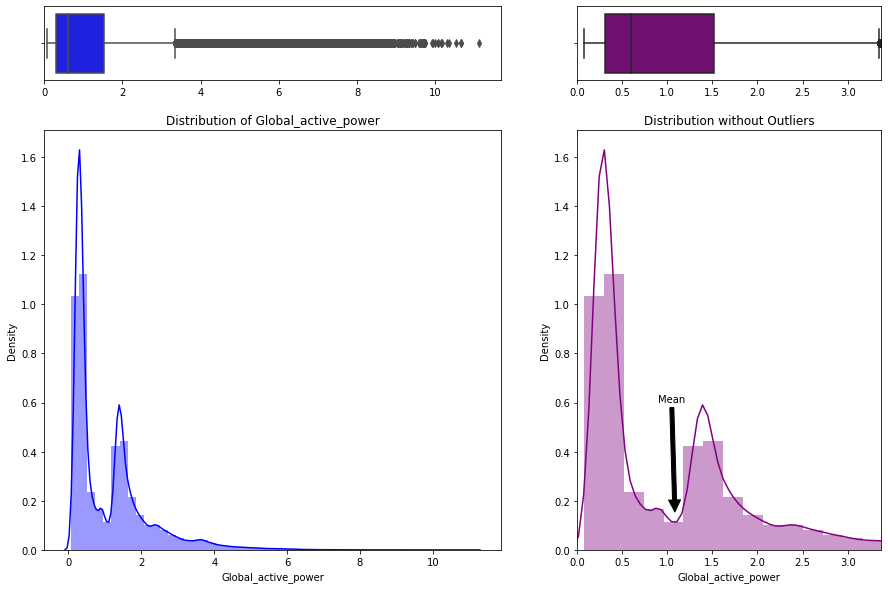

In [ ]:
f, axes = plt.subplots(2,
                       2, 
                       figsize=(15, 10), 
                       sharex=False, 
                       gridspec_kw={"height_ratios": (.15, .85),"width_ratios":(.60,.40)})
#Main boxplot
sns.boxplot(dataset["Global_active_power"] , color="blue", ax=axes[0,0])
axes[0,0].set_xlabel('')
axes[0,0].set_xlim(0, None)

#Main distribution
sns.distplot(dataset["Global_active_power"] , color="blue", ax=axes[1,0])
axes[0,0].set_xlim(0, None)
axes[1,0].set_title('Distribution of Global_active_power')

#Zoom boxplot
sns.boxplot(dataset["Global_active_power"], color="purple", ax=axes[0,1])
axes[0,1].set_xlabel('')
axes[0,1].set_xlim(0, 3.37)

#Zoom distribution
sns.distplot(dataset["Global_active_power"], color="purple", ax=axes[1,1])
axes[1,1].set_title('Distribution without Outliers')
axes[1,1].set_xlim(0, 3.37)

# Add an arrow to mark the mean value
axes[1,1].annotate(
'Mean', xy=(dataset["Global_active_power"].mean(), .15), xytext=(.9, .6),
arrowprops=dict(facecolor='black', shrink=0.01))
plt.show()



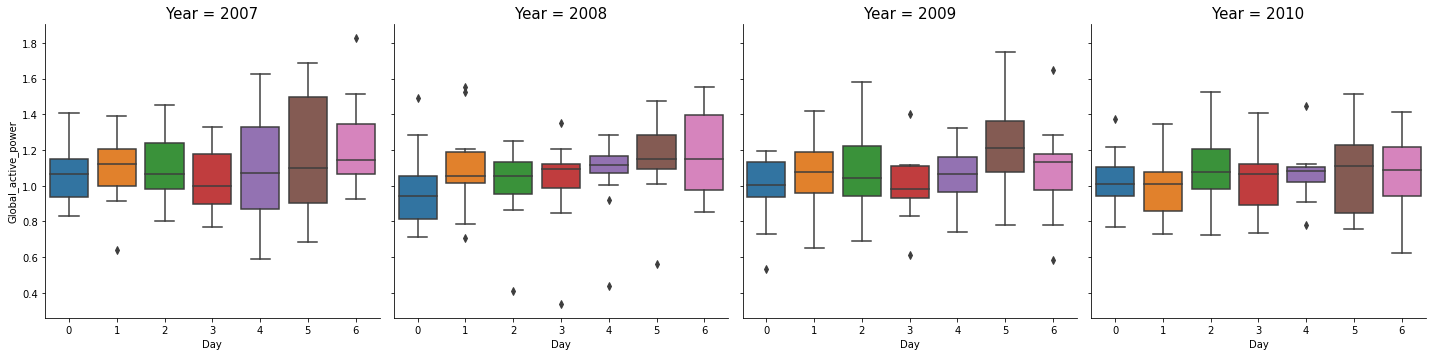

In [ ]:
energy_weekday_summary = dataset.groupby(by=['Year','Month','Day'], as_index=False)[['Global_active_power']].mean()

day_plot = sns.catplot(x="Day", y="Global_active_power", data=energy_weekday_summary.query("Year != 2006"), 
           kind="box",
           col="Year")
day_plot.set_titles(size = 15)

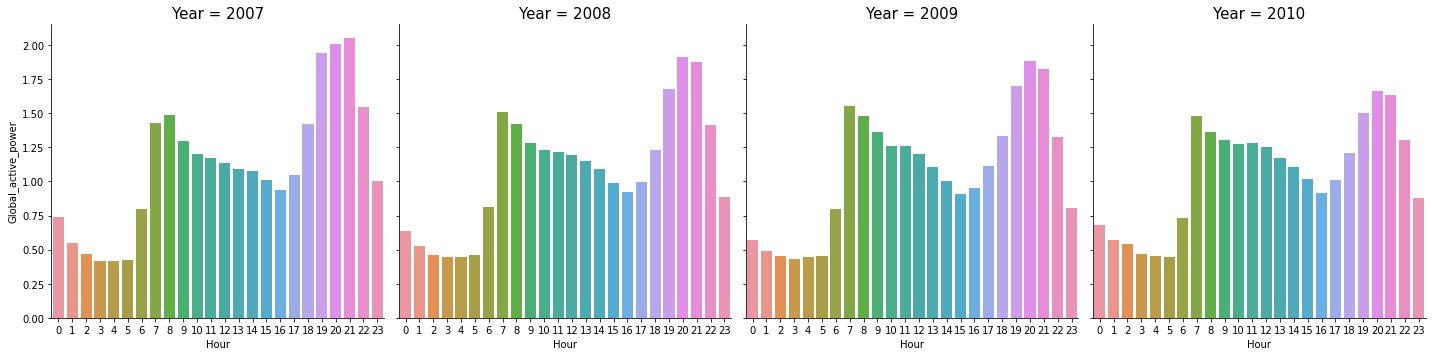

In [ ]:
energy_hourly_summary = dataset.groupby(by=['Year','Month','Day','Hour'], 
                                       as_index=False)[['Global_active_power']].mean()

hour_plot = sns.catplot(x="Hour", y="Global_active_power", data=energy_hourly_summary.query("Year != 2006"), 
           kind="bar",
           col="Year",
           ci=None)
hour_plot.set_titles(size = 15)

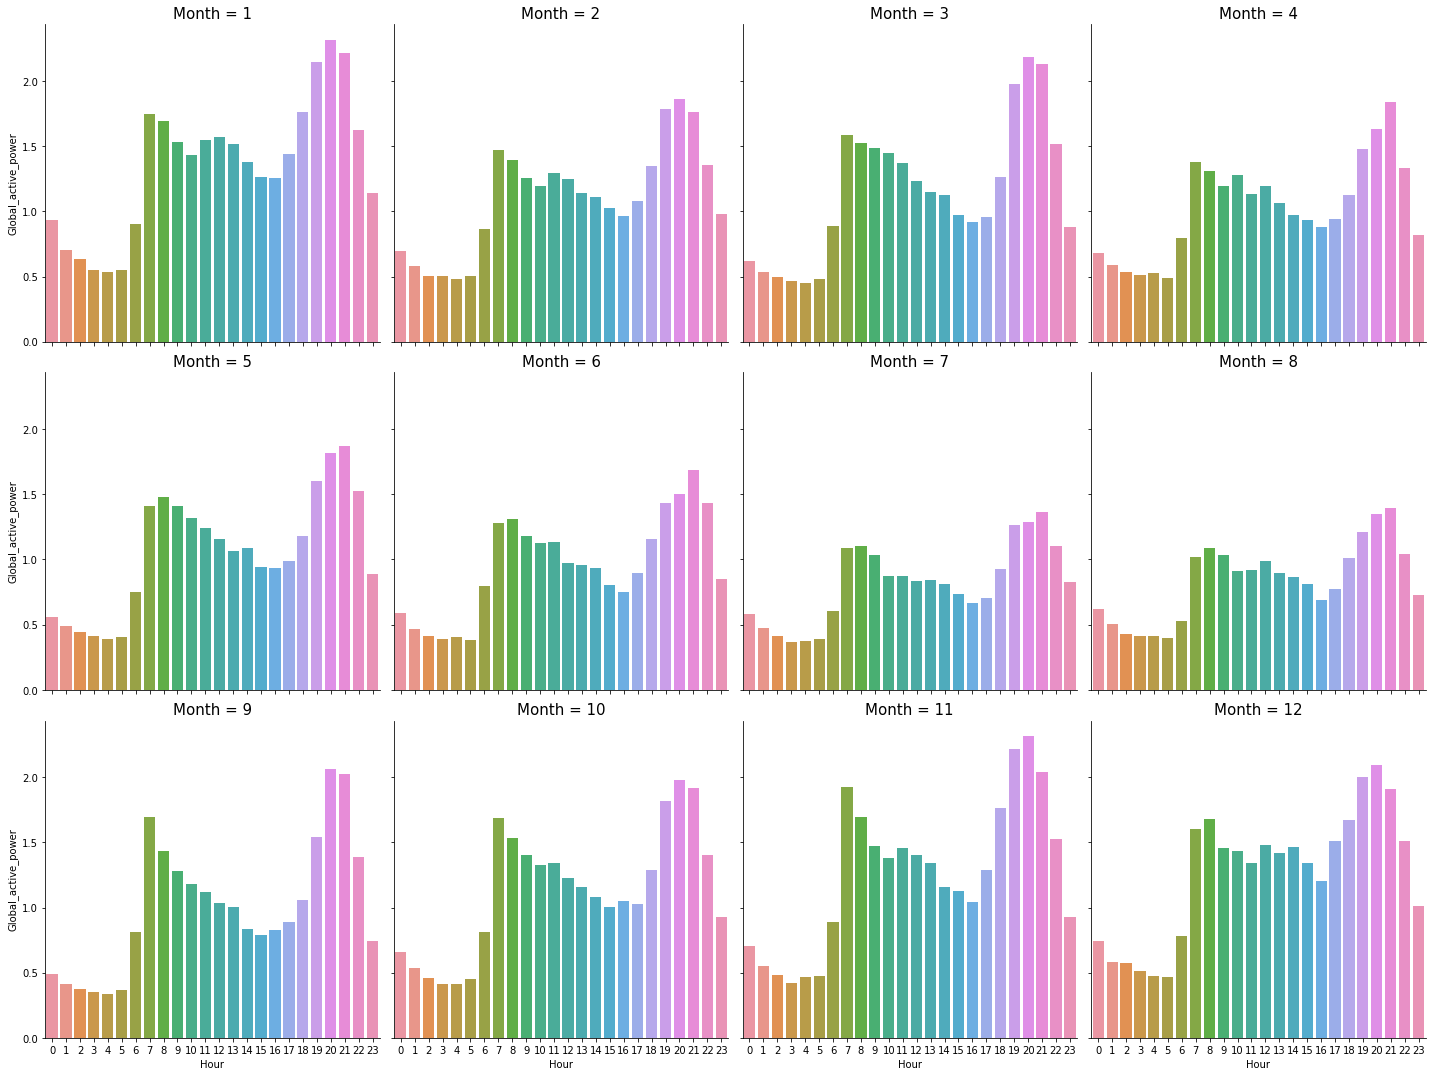

In [ ]:
current_palette = sns.color_palette("Paired")

hour_plot2 = sns.catplot(x="Hour", y="Global_active_power", data=energy_hourly_summary.query("Year != 2006"), 
           kind="bar",
           col="Month",
           col_wrap = 4,
           ci=None)
hour_plot2.set_titles(size = 15)

# **Pre-Process Data**

In [ ]:
from sklearn import preprocessing

#summarize by mean hourly energy
dataset_hourly_summary = dataset.groupby(by=['Year','Month','Day',"Hour"], as_index=False)[['Global_active_power']].mean()

#create the Label Encoder object
le = preprocessing.LabelEncoder()

#encode categorical data
dataset_hourly_summary['Year'] = le.fit_transform(dataset_hourly_summary['Year'])
dataset_hourly_summary.head()

,Year,Month,Day,Hour,Global_active_power
0,0,12,0,0,0.637967
1,0,12,0,1,0.760033
2,0,12,0,2,0.361233
3,0,12,0,3,0.449950
4,0,12,0,4,0.802500


In [ ]:
from sklearn.model_selection import train_test_split
x =dataset_hourly_summary[['Year','Month','Day','Hour']]
y = dataset_hourly_summary.Global_active_power
x_train,x_test,y_train,y_test=train_test_split(x, y, train_size=0.75, test_size = 0.25, random_state=1)


In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(x_train, y_train)
predictions=lm.predict(x_test)

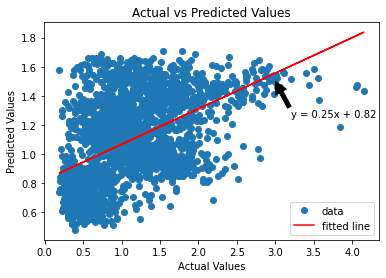

r-squared: 0.259503


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, predictions)

plt.plot(y_test, predictions, 'o', label='data')
plt.plot(y_test, intercept + slope*y_test, 'r', label='fitted line')
plt.legend()
plt.annotate(
'y = ' + str(round(slope,2)) + 'x' + ' + ' + str(round(intercept,2)), xy=(3, 1.5), xytext=(3.2, 1.25),
arrowprops=dict(facecolor='black', shrink=0.01))
plt.xlabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.ylabel('Predicted Values')
plt.show()
print("r-squared: %f" % r_value**2)

In [ ]:
print('Train Score: ', lm.score(x_train, y_train))  
print('Test Score: ', lm.score(x_test, y_test)) 

Train Score:  0.23714490820360834
Test Score:  0.2585973925931152


In [ ]:
errors=y_test-predictions
errors.head(10)

5293   -0.308269
4843    0.756691
4295   -0.663824
4522    0.400160
307     1.295844
5620   -0.452452
2745    0.541860
2878    0.547149
4247   -0.746676
509    -0.309696
Name: Global_active_power, dtype: float64

In [ ]:
print("MSE = ", np.mean(errors**2)) #MSE

MSE =  0.2899107269419883


In [ ]:
indexed_dataset = dataset[['Date_Time','Global_active_power', 'Year', 'Month']].set_index('Date_Time');
train = indexed_dataset[indexed_dataset['Year'] < 2010] #train set is years 2006 - 2009
test = indexed_dataset[indexed_dataset['Year'] == 2010] #test set is year 2010

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
train_monthly=train[['Global_active_power']].resample('W').mean()
mod = SARIMAX(train_monthly, order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 50), #50 = number of weeks that we are forcasting
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Global_active_power   No. Observations:                  160
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 50)   Log Likelihood                   8.351
Date:                            Mon, 30 May 2022   AIC                             -8.701
Time:                                    08:10:56   BIC                             -0.459
Sample:                                12-17-2006   HQIC                            -5.491
                                     - 01-03-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1642      0.148      1.107      0.268      -0.126       0.455
ma.L1         -1.0000    208.246     -0.005      0.996    -409.155     407.155
ar.S.L50      -0.5783      0.058    -10.039      0.000      -0.691      -0.465
sigma2         0.0415      8.647      0.005      0.996     -16.907      16.990
===================================================================================
Ljung-Box (Q):                       41.44   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.41   Prob(JB):                         0.70
Heteroskedasticity (H):               0.48   Skew:                            -0.04
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
results.forecast()

2010-01-10    1.021024
Freq: W-SUN, dtype: float64

In [ ]:
predictions = results.predict(start='2010-01-03', end='2010-12-19')

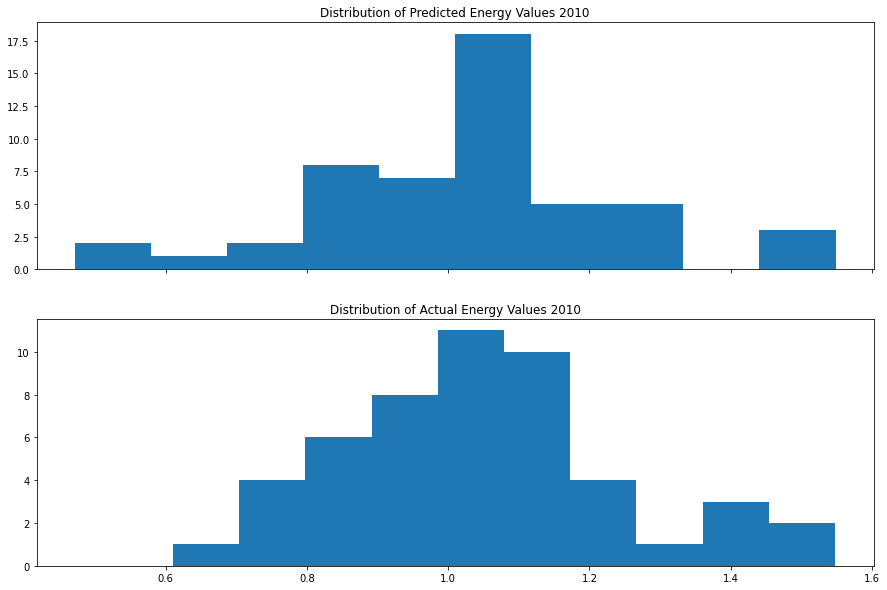

In [ ]:
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)
axes[0].hist(predictions.values, bins=10)
axes[0].set_title("Distribution of Predicted Energy Values 2010")
axes[1].hist((test[['Global_active_power']].resample('W').mean().values), bins=10)
axes[1].set_title("Distribution of Actual Energy Values 2010")
plt.show()

In [ ]:
test[['Global_active_power']].resample('W').mean().reset_index()
prediction = pd.DataFrame(predictions).reset_index()
prediction.columns = ['Date_Time','Global_active_power']

res = pd.merge(test[['Global_active_power']].resample('W').mean(), 
               prediction, 
               how='left', 
               on='Date_Time')

res.columns = ['Date_Time','actual','predictions']
res.insert(3, 'residuals', res['actual'] - res['predictions']) #residuals
res.head()

,Date_Time,actual,predictions,residuals
0,2010-01-03,0.976101,1.512270,-0.536168
1,2010-01-10,0.920572,1.021024,-0.100452
2,2010-01-17,1.451530,1.305797,0.145732
3,2010-01-24,1.535291,1.039392,0.495900
4,2010-01-31,1.548028,0.853607,0.694422


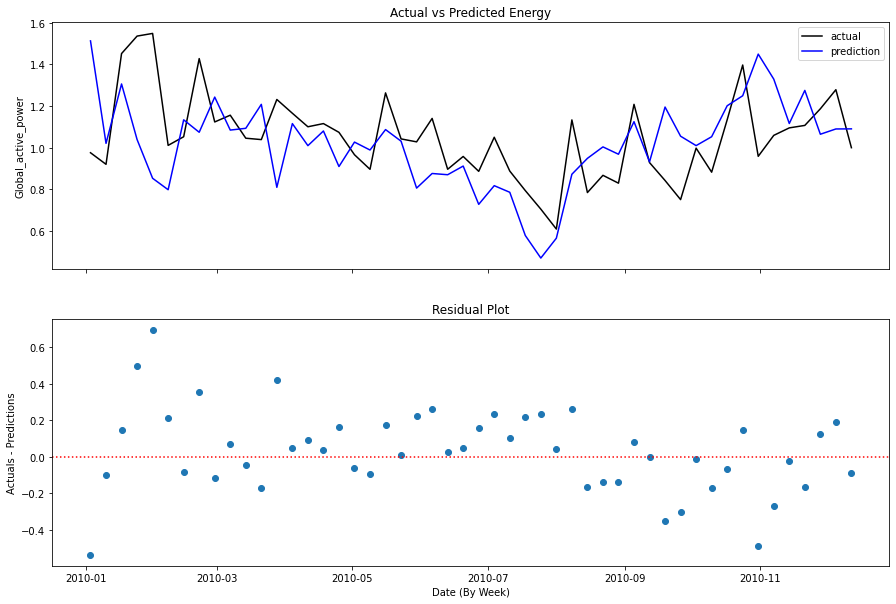

MSE =  0.05315918132922282


In [ ]:
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)

#plot of actual vs predictions
axes[0].plot(res['Date_Time'],res['actual'], color='black', label='actual')
axes[0].plot(res['Date_Time'],res['predictions'], color='blue', label='prediction')
axes[0].set_title('Actual vs Predicted Energy')
axes[0].set_ylabel('Global_active_power')
axes[0].legend()

#plot of actual - predictions
axes[1].scatter(res['Date_Time'],(res['actual'] - res['predictions']))
axes[1].set_title('Residual Plot')
axes[1].set_xlabel('Date (By Week)')
axes[1].set_ylabel('Actuals - Predictions')
axes[1].axhline(y=0, color='r', linestyle=':')

plt.show()

#MSE
print("MSE = ", np.mean(res['residuals']**2)) #MSE

In [ ]:
train_2 = train.resample('D').mean().reset_index()
train_2 = train_2[['Date_Time', 'Global_active_power']]
train_2.columns = ['ds', 'y']
train_2.head()

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


In [ ]:
test_2 = test.resample('D').mean().reset_index()
test_2 = test_2[['Date_Time', 'Global_active_power']]
test_2.columns = ['ds', 'y']
test_2.head()

,ds,y
0,2010-01-01,0.850175
1,2010-01-02,1.176235
2,2010-01-03,0.901894
3,2010-01-04,1.171833
4,2010-01-05,0.916776


In [ ]:
ph = Prophet(weekly_seasonality=False)
ph.add_seasonality(name='daily', period=1, fourier_order=8)
ph.fit(train_2)

INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


In [ ]:
future = ph.make_future_dataframe(periods=365)
forecast = ph.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2006-12-16,1.481346,0.968955,1.973085
1,2006-12-17,1.490966,0.983630,1.971138
2,2006-12-18,1.500738,0.948138,1.995819
3,2006-12-19,1.510410,1.027290,2.039660
4,2006-12-20,1.519724,0.994889,2.025206


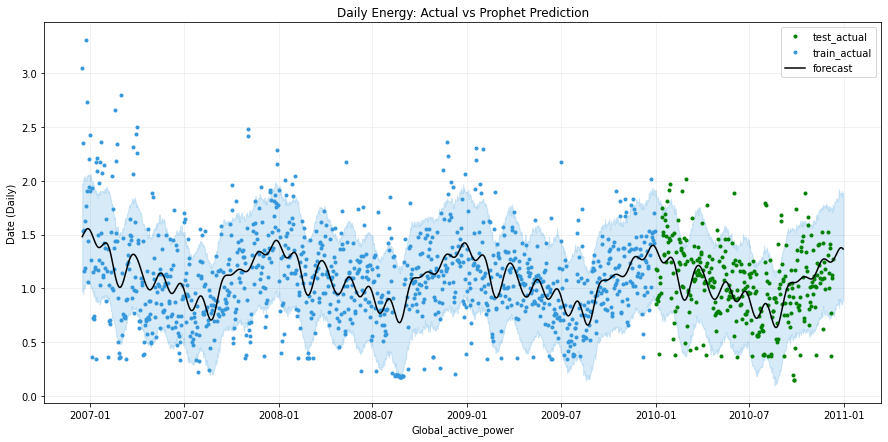

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(test_2.ds, test_2.y, '.', color='green', label = "test_actual")
plt.plot(train_2.ds, train_2.y, '.', color='#3498db', label = "train_actual")
plt.plot(forecast.ds, forecast.yhat, color='black', label = "forecast")
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.ylabel('Date (Daily)')
plt.legend()
plt.show()

In [ ]:
res2 = pd.merge(test_2, 
               forecast[['ds','yhat']], 
               how='left', 
               on='ds')
res2.columns = ['Date_Time','actual','predictions']
res2.insert(3, 'residuals', res2['actual'] - res2['predictions']) #residuals
res2.head()

,Date_Time,actual,predictions,residuals
0,2010-01-01,0.850175,1.378715,-0.528540
1,2010-01-02,1.176235,1.369701,-0.193466
2,2010-01-03,0.901894,1.359535,-0.457641
3,2010-01-04,1.171833,1.348451,-0.176618
4,2010-01-05,0.916776,1.336704,-0.419928


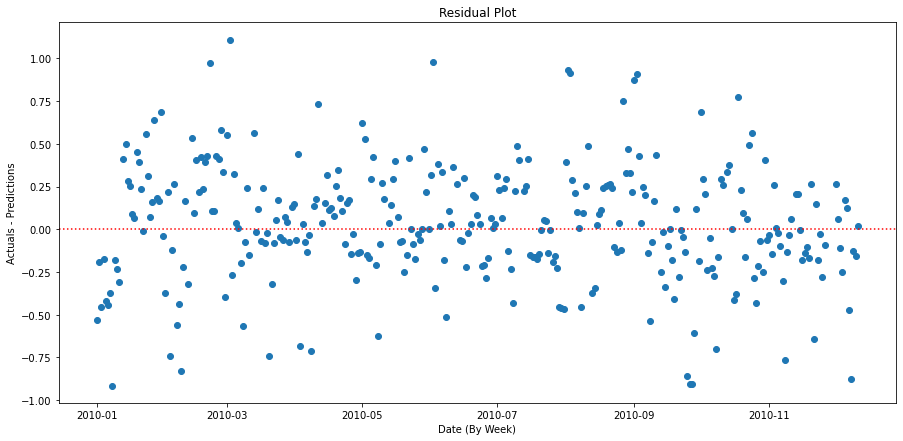

MSE =  0.11789891103397096


In [ ]:
fig = plt.gcf()
fig.set_size_inches(15, 7)

#plot of residuals
plt.scatter(res2['Date_Time'],(res2['residuals']))
plt.title('Residual Plot')
plt.xlabel('Date (By Week)')
plt.ylabel('Actuals - Predictions')
plt.axhline(y=0, color='r', linestyle=':')

plt.show()

#MSE
print("MSE = ", np.mean(res2['residuals']**2)) #MSE